In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import pickle


In [ ]:
def scrape_goodreads(category):
    url = f"https://www.goodreads.com/search?utf8=%E2%9C%93&q={category}&search_type=books"
    req = requests.get(url, headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/124.0.0.0 Safari/537.36'})

    content = BeautifulSoup(req.content, 'html.parser')
    books = content.find_all('a', class_='bookTitle')
    authors = content.find_all('a', class_="authorName")

    data = []
    for book, author in zip(books, authors):
        book_name = book.find('span', itemprop='name').text.strip()
        author_name = author.find('span', itemprop='name').text.strip()
        data.append({'Book': book_name, 'Author': author_name})

    return json.dumps(data, indent=4)

In [ ]:
# category = input("Enter the searching category - Name of the book / Genre / Author: ")
# json_output = scrape_goodreads(category)
# print(json_output)

In [ ]:
import random
import numpy as np

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data_file = open('capstoneIndentPart1.json').read()
intents = json.loads(data_file)

In [ ]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']

In [ ]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)

        # adding documents
        documents.append((w, intent['tag']))

        # adding classes to our class list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")
print (len(words), "unique lemmatized words")
print (len(classes), "classes", classes)

241 documents
135 unique lemmatized words
4 classes ['book_search', 'goodbye', 'greeting', 'thanks']


In [ ]:
# Create the training data
training_data = []
for doc in documents:
    # Create a bag of words for each document
    bag = [1 if word in doc[0] else 0 for word in words]
    # Add the bag of words and the output row to the training data
    training_data.append([bag, doc[1]])

# Find the maximum length of any list in the training list
max_length = max(len(bag) for bag, _ in training_data)

# Pad all lists in the training list to the maximum length
padded_training = [
    (np.pad(bag, (0, max_length - len(bag)), 'constant'), output_row)
    for bag, output_row in training_data
]
training = np.array(padded_training, dtype=object)

In [ ]:
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # Correct bag of words creation
    bag = [1 if w in doc[0] else 0 for w in words]  # This creates a list with 1 or 0 directly
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

# Shuffle and convert to numpy arrays
random.shuffle(training)
# Convert list of lists to numpy array properly
train_x = np.array([np.array(elem[0]) for elem in training])
train_y = np.array([np.array(elem[1]) for elem in training])

# Now, print shapes to confirm
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y.shape)

Shape of train_x: (241, 135)
Shape of train_y: (241, 4)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.3, random_state=42)

# Print the shapes to verify
print(f"train_x shape: {train_x.shape}, train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}, test_y shape: {test_y.shape}")

train_x shape: (168, 135), train_y shape: (168, 4)
test_x shape: (73, 135), test_y shape: (73, 4)


In [ ]:
# Build the model
model = Sequential([
    Dense(128, input_shape=(len(train_x[0]),), activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(train_y[0]), activation='softmax')
])

sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Epoch 1/50
19/19 [==============================] - 1s 35ms/step - loss: 0.3512 - accuracy: 0.8411 - val_loss: 0.0953 - val_accuracy: 1.0000
Epoch 2/50
19/19 [==============================] - 0s 17ms/step - loss: 0.3414 - accuracy: 0.8742 - val_loss: 0.0958 - val_accuracy: 1.0000
Epoch 3/50
19/19 [==============================] - 0s 17ms/step - loss: 0.3527 - accuracy: 0.8675 - val_loss: 0.1047 - val_accuracy: 1.0000
Epoch 4/50
19/19 [==============================] - 0s 16ms/step - loss: 0.3141 - accuracy: 0.8742 - val_loss: 0.1013 - val_accuracy: 1.0000
Epoch 4: early stopping
Epoch 1/50
19/19 [==============================] - 1s 35ms/step - loss: 0.2927 - accuracy: 0.8742 - val_loss: 0.3850 - val_accuracy: 0.8824
Epoch 2/50
19/19 [==============================] - 0s 11ms/step - loss: 0.3072 - accuracy: 0.8940 - val_loss: 0.3666 - val_accuracy: 0.8824
Epoch 3/50
19/19 [==============================] - 0s 10ms/step - loss: 0.2868 - accuracy: 0.8940 - val_loss: 0.3696 - val_accura

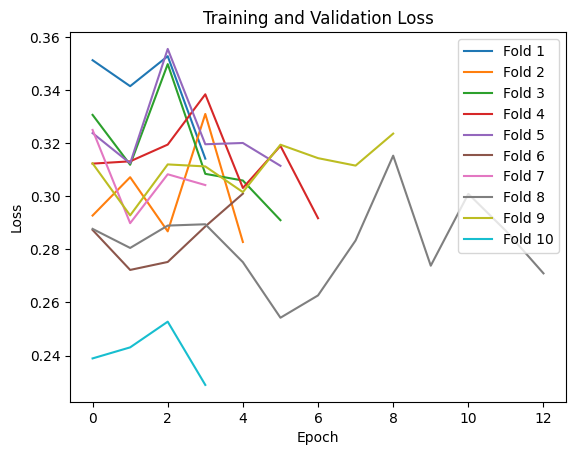

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Define the number of splits for k-fold cross-validation
n_splits = 10

# Initialize the Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store the accuracy scores and history objects
scores = []
all_history = []

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose = 1)

# Perform k-fold cross-validation
for train_index, test_index in skf.split(train_x, np.argmax(train_y, axis=1)):
    X_train, X_test = train_x[train_index], train_x[test_index]
    y_train, y_test = train_y[train_index], train_y[test_index]


    # Fit the model on the training data and store the history
    history = model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1,
                        validation_data=(X_test, y_test), callbacks=[early_stopping])
    all_history.append(history)

    # Evaluate the model on the test data
    score = model.evaluate(X_test, y_test, verbose=0)
    scores.append(score[1])

# Calculate and print the mean accuracy and standard deviation
print(f"Mean Accuracy: {np.mean(scores):.4f}, StdDev: {np.std(scores):.4f}")

# Plot the training and validation loss for each fold
for i, history in enumerate(all_history):
    plt.plot(history.history['loss'], label=f"Fold {i+1}")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()



In [ ]:
loss, accuracy = model.evaluate(test_x, test_y, verbose=1)

print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

3/3 [==============================] - 0s 5ms/step - loss: 0.2648 - accuracy: 0.9178
Test Loss: 0.2648, Test Accuracy: 0.9178


In [ ]:
# Fit model
# hist = model.fit(train_x, train_y, epochs=500, batch_size=5, verbose=1)

# Save model
model.save('chatbot_model.h5')

print("Model Created")

Model Created


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]

    return sentence_words

In [ ]:
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)

    # bag of words - matrix of N words, vocabulary matrix
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:

                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)

    return(np.array(bag))

In [ ]:
def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.35
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]

    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})

    return return_list

In [ ]:
def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            if tag == 'book_search':
              category = input("Sure, I'd be happy to recommend a book. What type of book are you in the mood for? ")
              result = scrape_goodreads(category)
            else:
              result = random.choice(i['responses'])
            break

    return result

In [ ]:
def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res

In [ ]:
chatbot_response('thank you')

1/1 [==============================] - 0s 42ms/step


"You're welcome! If you need assistance, feel free to ask."